In [1]:
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import scipy.linalg as lng
import matplotlib
from sklearn.cluster import KMeans
import operator
%matplotlib qt
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import statsmodels.formula.api as smf
import statsmodels.api as sm
import mord
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import random
import copy
import math
from sklearn.tree import export_graphviz
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pydot
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [2]:
def center(X):
    """ Center the columns (variables) of a data matrix to zero mean.
        
        X, MU = center(X) centers the observations of a data matrix such that each variable
        (column) has zero mean and also returns a vector MU of mean values for each variable.
     """ 
    n = X.shape[0]
    mu = np.mean(X,0)
    #X = X - np.ones((n,1)) * mu
    X = X - mu
    
    return X, mu

In [3]:
def normalize(X):
    """Normalize the columns (variables) of a data matrix to unit Euclidean length.
    X, MU, D = normalize(X)
    i) centers and scales the observations of a data matrix such
    that each variable (column) has unit Euclidean length. For a normalized matrix X,
    X'*X is equivalent to the correlation matrix of X.
    ii) returns a vector MU of mean values for each variable.
    iii) returns a vector D containing the Euclidean lengths for each original variable.
    
    """

    n = np.size(X, 0)
    X, mu = center(X)
    #X = np.ma.array(X, mask=np.isnan(X))
    
    # find the norm of each column, but only removing the nan values from that column
    d_compile = list()
    for column_ in X.columns:
        Xcopy = copy.deepcopy(X)
        Xcopy.dropna(subset = [column_], inplace=True )
        d_compile.append(np.linalg.norm(Xcopy[column_], ord=2))
        
    #d = np.linalg.norm(X[~np.isnan(X)], ord = 2, axis = 0)
    if len(np.where(d_compile==0)[0]) > 1:
        d_compile[np.where(d_compile==0)[0]] = 1
    X = np.divide(X, np.ones((n,1)) * d_compile)
    return X, mu, d_compile

In [4]:
data = pd.read_excel(r'C:\DTU\Data\201901_JanuaryExpt\DataExtracted\MachineLearning\Subject_Block_Session_Trial.xlsx')

data.dropna(subset=['ScoreDifficulty'], inplace=True, axis=0) # drop only nan in ScoreDifficulty
Y1_wNanInData = np.array(data.ScoreDifficulty.tolist())


data_woNa = data.dropna(inplace=False, axis=0) # drop nan values in all data
Y1 = data_woNa.ScoreDifficulty.tolist() # Y corresponding to data

#Y = [int(item) for item in Y]

#X = data.drop(['ScoreDifficulty'], axis = 1)

# drop some variables that are higher correlated to some other variables
#data_new = data_woNa.drop(['PupilAbsolute_Median', 'BlinkCount', 'PupilRelative_Median', 'Subject', 'EffectiveTime'], axis=1)


# convert some data to categorical first
cols_categorical = ['Subject', 'Day', 'DayDT', 'TypingTechnique', 'Session', 'Trial', 'ScoreDifficulty']
for cols in cols_categorical:
    data[cols] = data[cols].astype('category')

X = data.drop(['ScoreDifficulty', 'Subject', 'Day', 'DayDT', 'TypingTechnique', 'Session', 'Language',\
                   'SessionDifficulty', 'Trial'], axis = 1)

Y_woNa = np.array(data_woNa.ScoreDifficulty.tolist())
X_woNa = data_woNa.drop(['ScoreDifficulty', 'Subject', 'Day', 'DayDT', 'TypingTechnique', 'Session', 'Language',\
                   'SessionDifficulty', 'Trial'], axis = 1)
#X.drop(['ScoreDifficulty'], axis=1, inplace=True)

X_norm, mu, d = normalize(X)

X_norm_woNa, mu, d = normalize(X_woNa)


In [5]:
"""
for columnPlot in data.columns:
    if columnPlot not in ['ScoreDifficulty', 'Subject', 'Day', 'DayDT', 'Session', 'SessionDifficulty', 'Trial','Language'\
                    ,'Fatigue', 'TypingTechnique']:
        #print(columnPlot)
        data.boxplot(column=columnPlot, by='ScoreDifficulty')
        fileName = r'C:\DTU\Results\201901_Expt\Fatigue\PerceivedScoreCorrelations' + '\\' + columnPlot + '.png'
        plt.savefig(fileName, dpi=300)
        plt.close()
        
"""

"\nfor columnPlot in data.columns:\n    if columnPlot not in ['ScoreDifficulty', 'Subject', 'Day', 'DayDT', 'Session', 'SessionDifficulty', 'Trial','Language'                    ,'Fatigue', 'TypingTechnique']:\n        #print(columnPlot)\n        data.boxplot(column=columnPlot, by='ScoreDifficulty')\n        fileName = r'C:\\DTU\\Results\x81901_Expt\\Fatigue\\PerceivedScoreCorrelations' + '\\' + columnPlot + '.png'\n        plt.savefig(fileName, dpi=300)\n        plt.close()\n        \n"

In [6]:
from sklearn import preprocessing, metrics


le = preprocessing.LabelEncoder()
le.fit(Y1_wNanInData)
le.classes_
Y_wNanInData = le.transform(Y1_wNanInData)

X_norm_wY = copy.deepcopy(X_norm)
X_norm_wY['y'] = Y_wNanInData


le = preprocessing.LabelEncoder()
le.fit(Y_woNa)
le.classes_
Y_woNanInData = le.transform(Y_woNa)

X_norm_woNa_wY = copy.deepcopy(X_norm_woNa)
X_norm_woNa_wY['y'] = Y_woNanInData

## PCA

In [7]:
n, p = np.shape(X_norm_woNa)
u, d, v = np.linalg.svd(X_norm_woNa)

# Plot the two components and see if the perceived difficulty levels are differentiated
L = v # the loading
k = len(d)
d = d[0:k]
u = u[:, :k]
v = v[:k, :] # Matrix that is returned from svd is ordered differently, therefor different slicing

S = np.matmul(u, np.diag(d)) # The scores


(0, 105)

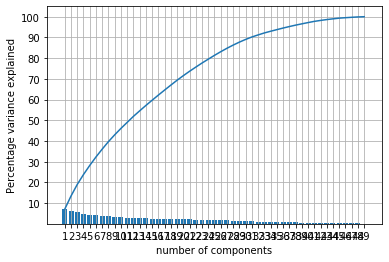

In [8]:
d_varianceExplained = list()
# Plot the variance explained by n components:

plt.figure()
plt.bar(range(1, len(d)+1), (d/sum(d))*100)

for i in range(1, len(d)+1):
    #print(len(d[0:i]), (sum(d[0:i])/sum(d))*100)
    d_varianceExplained.append((sum(d[0:i])/sum(d))*100)

plt.grid(b=True)
#d_varianceExplained = (d[0]/sum(d))*100
plt.plot(range(1, len(d)+1), d_varianceExplained)
plt.xlabel('number of components')
plt.ylabel('Percentage variance explained')
plt.xticks(range(1,len(d)+1))
plt.yticks(range(10,110,10))
plt.ylim([0,105])

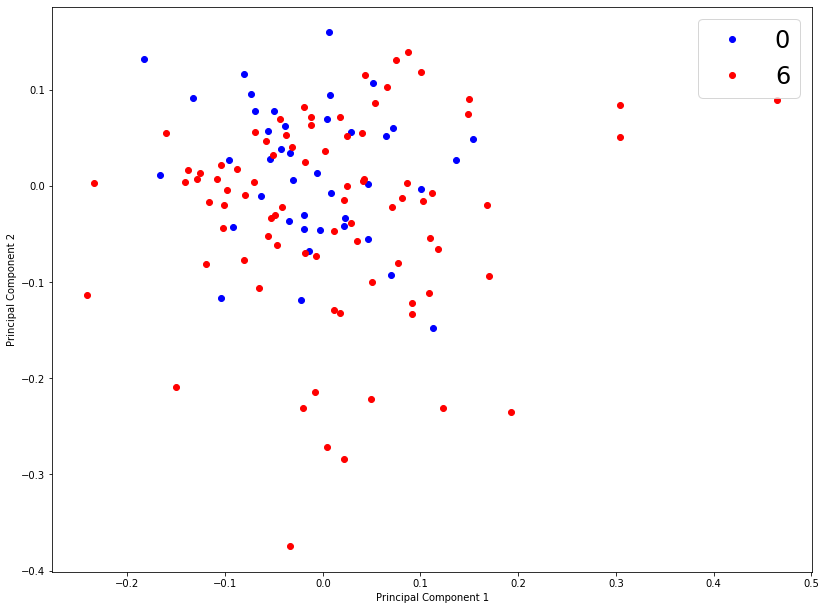

In [9]:

# for perceived score of 1, plot pc2 vs pc1:
#colorList = ['b', 'r', 'y', 'c', 'm', 'pink', 'g']

indices = Y_woNanInData==0
plt.figure(figsize=(12, 9))
plt.plot(S[indices, 0], S[indices, 1], 'ob', label=0)

indices = Y_woNanInData==6
plt.plot(S[indices, 0], S[indices, 1], 'or', label=6)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

#for i in range(1,8):
#    indices = Y==i
#    plt.plot(S[indices, 1], S[indices,0], 'o', markerfacecolor=colorList[i-1], markeredgecolor=colorList[i-1], label=i)
plt.rcParams.update({'font.size': 24})
plt.legend()
plt.tight_layout()
#plt.savefig(r'M:\Documents\Courses\Credits\2019_04_August\Computational Data Analysis\Project\Results\perceivedDifficulty\PCA\PC1_PC2', dpi=600)


Text(0.5, 1.0, 'Scree plot')

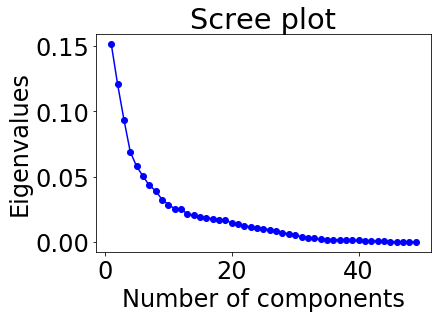

In [10]:
# Scree plot
sigma2 = d ** 2 / sum(d**2)
plt.figure()
plt.plot(range(1,len(d)+1), sigma2, '-ob')
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')
plt.title('Scree plot')

Var1 : PupilAbsolute_baseline
Var2 : PupilRelative_readingStart
Var3 : PupilRelative_readingEnd
Var4 : PupilRelative_writingStart
Var5 : PupilRelative_writingEnd
Var6 : PupilRelative_readingMean
Var7 : PupilRelative_readingMedian
Var8 : PupilRelative_readingMin
Var9 : PupilRelative_reading5pctMax
Var10 : PupilRelative_writingMean
Var11 : PupilRelative_writingMedian
Var12 : PupilRelative_writingMin
Var13 : PupilRelative_writing5pctMax
Var14 : PupilStdLeft
Var15 : PupilStdRight
Var16 : PupilFatigueRatio_baseline
Var17 : LHIPA_writing
Var18 : BlinkFrequency_reading
Var19 : BlinkDurationAverage_reading
Var20 : InterBlinkDuration_reading
Var21 : BlinkFrequency_writing
Var22 : BlinkDurationAverage_writing
Var23 : InterBlinkDuration_writing
Var24 : BlinkLongFrequency
Var25 : InterBlinkLongDuration
Var26 : BlinkBurstFrequency_reading
Var27 : BlinkBurstToTotalBlinksRatio_reading
Var28 : BlinkBurstFrequency_writing
Var29 : BlinkBurstToTotalBlinksRatio_writing
Var30 : BlinkBurstFrequency_trial
Va

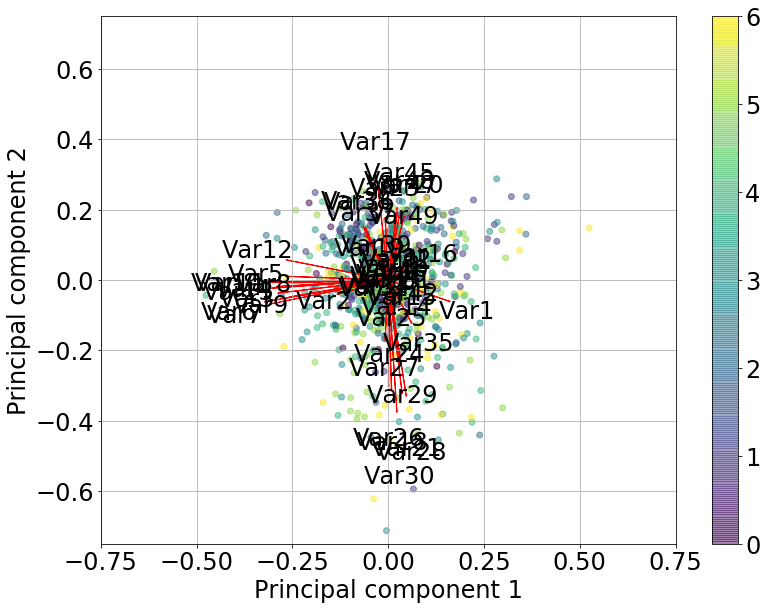

In [11]:
# Biplot and factor loadings
xs = S[:,0]
ys = S[:,1]
coeff = np.transpose(v[0:2,:])
n = coeff.shape[0]

scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())
plt.figure(figsize=(12, 9))
plt.scatter(xs * scalex,ys * scaley, c = Y_woNanInData, alpha=0.5)
plt.colorbar()

for i in range(n):
    
    label_ = 'Var'+str(i+1)+' : '+X_norm_woNa.columns[i]
    print(label_)
    plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'r', alpha = 1)
    plt.text(coeff[i,0]*1.3, coeff[i,1]*1.5, "Var"+str(i+1), color = 'black', ha = 'center', va = 'center')
    
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.xlim(-0.75,0.75)
plt.ylim(-0.75,0.75)

plt.grid()
plt.rcParams.update({'font.size': 24})
plt.tight_layout()
#plt.savefig(r'M:\Documents\Courses\Credits\2019_04_August\Computational Data Analysis\Project\Results\perceivedDifficulty\PCA\loadings', dpi=600)

In [12]:
coeff

array([[ 0.15850078, -0.06029535],
       [-0.12973995, -0.03982389],
       [-0.2840175 , -0.03683509],
       [-0.28848367, -0.01849294],
       [-0.26426079,  0.0103175 ],
       [-0.31940561, -0.06174122],
       [-0.30708085, -0.06807298],
       [-0.24933622, -0.00802533],
       [-0.25547278, -0.04810246],
       [-0.3237059 , -0.00632355],
       [-0.31688613, -0.00731512],
       [-0.2624609 ,  0.05634587],
       [-0.30112925, -0.02317127],
       [ 0.01682424, -0.05212114],
       [ 0.02808439, -0.03298846],
       [ 0.0698883 ,  0.0486612 ],
       [-0.02614602,  0.26032619],
       [ 0.00853131, -0.30713285],
       [-0.03771413,  0.05907355],
       [ 0.04081213,  0.17832854],
       [ 0.03619163, -0.31985492],
       [ 0.0167247 ,  0.0383716 ],
       [-0.00750859,  0.17387188],
       [ 0.00334826, -0.14027803],
       [ 0.00630515, -0.07333624],
       [ 0.00110865, -0.29991269],
       [-0.00774563, -0.16732637],
       [ 0.04676966, -0.32685879],
       [ 0.02900756,

# Metrics to compare models

In [13]:
maeTrainMean, maeTrainStd, maeTestMean, maeTestStd, accuracyMean, accuracyStd = dict(), dict(), dict(), dict(), dict(), \
dict()

# REGRESSION

## Random Forests 
Model optimization

## On complete data

In [14]:
def rfr_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (20, 50, 100, 200, 300, 500, 700, 1000),
            'max_features' : (4,5,6,7,8,9,10)
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    print('optimized parameters: ', best_params)
    
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],
                                max_features=best_params["max_features"], random_state=False, verbose=False)
    # Perform K-Fold CV
    scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')

    return scores, best_params

In [15]:
scores_rfr, bestParams_rfr = rfr_model(X_norm_woNa, Y_woNa)
print('Neg_mean_absolute error: ', np.mean(scores_rfr), np.std(scores_rfr))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


optimized parameters:  {'max_depth': 6, 'max_features': 10, 'n_estimators': 300}
Neg_mean_absolute error:  -1.2633389654457117 0.19636844966465705


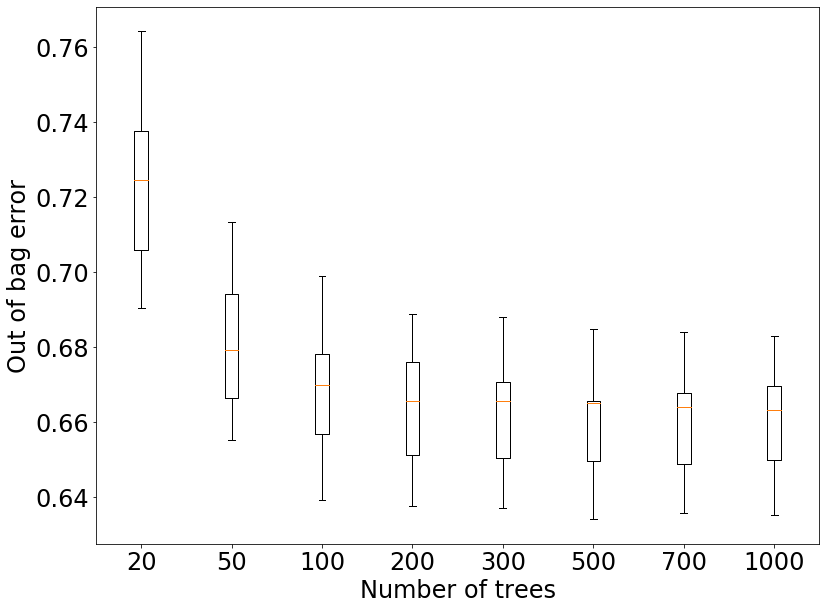

In [16]:
skf = StratifiedKFold(n_splits=10)
# Plot oob error
maeOOBList = list()

plt.figure(figsize=(12,9))

for j, nTrees in enumerate([20, 50, 100, 200, 300, 500, 700, 1000]):
    maeOOBList = list()
    
    for train_index, test_index in skf.split(X_norm_woNa, Y_woNa):
    
        X_train, X_test = X_norm_woNa.iloc[train_index], X_norm_woNa.iloc[test_index]
        y_train, y_test = Y_woNa[train_index], Y_woNa[test_index]
        
        rf = RandomForestRegressor(max_depth=6, n_estimators=nTrees,
                                   max_features=8, random_state=False, verbose=False, 
                                   oob_score=True)
        
        
        #rf = RandomForestRegressor(max_depth=bestParams_rfr["max_depth"], n_estimators=nTrees,
        #                           max_features=bestParams_rfr["max_features"], random_state=False, verbose=False, 
        #                           oob_score=True)
        # Train the model on training data
        rf.fit(X_train, y_train)
    
        # Use out-of-bag prediction scores to estimate the number of trees
        maeOOBList.append(1-(rf.oob_score_))
        
    plt.boxplot(maeOOBList, positions=[j+1])
        
plt.xlabel('Number of trees')
plt.ylabel('Out of bag error')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], [20, 50, 100, 200, 300, 500, 700, 1000])
plt.rcParams.update({'font.size': 24})
plt.tight_layout()
#plt.savefig(r'M:\Documents\Courses\Credits\2019_04_August\Computational Data Analysis\Project\Results\perceivedDifficulty\Random Forests\oobError_modelSelection', dpi=600)

Variable importance

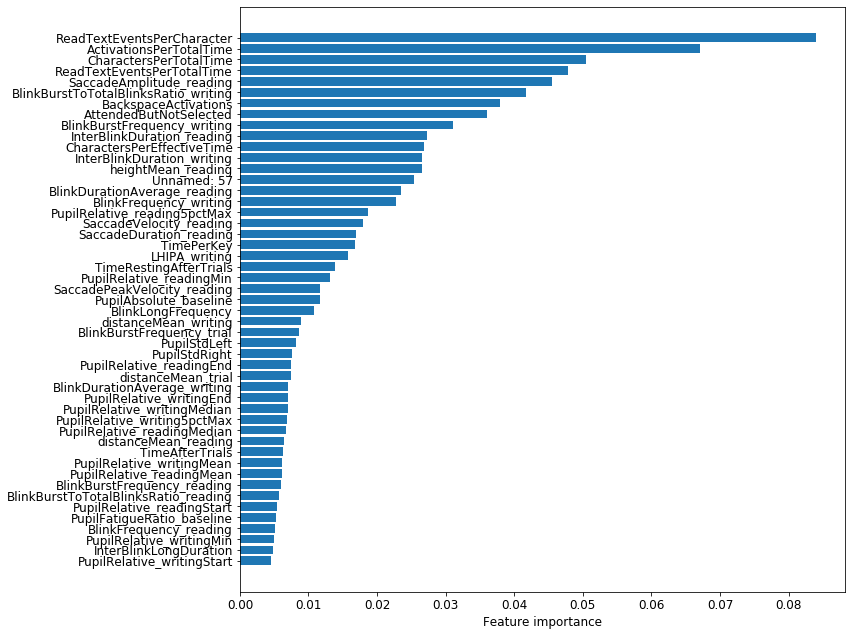

In [17]:
plt.rcParams.update({'font.size': 12})
perm = PermutationImportance(rf, cv = None, refit = False, n_iter = 50).fit(X_train, y_train)

imp_df = pd.DataFrame({'feature': X_train.columns.values,
                       'importance': perm.feature_importances_})

# Reorder by importance
ordered_df = imp_df.sort_values(by='importance')
imp_range=range(1,len(imp_df.index)+1)

## Barplot with confidence intervals
height = ordered_df['importance']
bars = ordered_df['feature']
y_pos = np.arange(len(bars))

plt.figure(figsize=(12,9))
# Create horizontal bars
plt.barh(y_pos, height)

# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel("Feature importance")

plt.tight_layout()
# Show graphic
plt.savefig(r'C:\DTU\Results\201901_Expt\MachineLearning\PerceivedDifficulty_RF_variable_importance', dpi=600)


In [18]:
skf = StratifiedKFold(n_splits=10)

maeTrain_rf, maeTest_rf = list(), list()
accuracy_rf = list()

for train_index, test_index in skf.split(X_norm_woNa, Y_woNa):
    
    X_train, X_test = X_norm_woNa.iloc[train_index], X_norm_woNa.iloc[test_index]
    y_train, y_test = Y_woNa[train_index], Y_woNa[test_index]
    
    rf = RandomForestRegressor(max_depth=bestParams_rfr["max_depth"], n_estimators=bestParams_rfr["n_estimators"],
                                max_features=bestParams_rfr["max_features"], random_state=False, verbose=False)
    # Train the model on training data
    rf.fit(X_train, y_train)
    
    # Training data metrics:
    maeTrain_rf.append(1-(rf.score(X_train, y_train)))
    
    # testing data metrics:
    maeTest_rf.append(1-(rf.score(X_test, y_test)))
    # Use the forest's predict method on the test data
    test_pred = rf.predict(X_test)
    # Calculate the absolute errors
    errors = np.sqrt((test_pred - y_test)**2)    
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / (y_test+1))
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    accuracy_rf.append(accuracy)    
    

maeTrainMean['rf'] = np.mean(maeTrain_rf)
maeTrainStd['rf']= np.std(maeTrain_rf)

maeTestMean['rf'] = np.mean(maeTest_rf)
maeTestStd['rf']= np.std(maeTest_rf)

accuracyMean['rf'] = np.mean(accuracy_rf)
accuracyStd['rf'] = np.std(accuracy_rf)

print('TRAINING DATA')    
print('Mean of mean absolute error', np.mean(maeTrain_rf), 'with std: ', np.std(maeTrain_rf))
print('')

print('TESTING DATA')
print('Mean of mean absolute error', np.mean(maeTest_rf), 'with std: ', np.std(maeTest_rf))
print('Mean accuracy: ', np.mean(accuracy_rf), 'with std: ', np.std(accuracy_rf))

TRAINING DATA
Mean of mean absolute error 0.3298376737365968 with std:  0.008269674875661414

TESTING DATA
Mean of mean absolute error 0.7686433044481763 with std:  0.120444622441329
Mean accuracy:  70.21128956069442 with std:  2.5850824437239144


# Decision Tree

model selection

In [19]:
def dtr_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=DecisionTreeRegressor(criterion='mae', ),
        param_grid={
            'max_depth': range(3,7),
            'max_features' : (4,5,6,7,8,9,10)
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    print('optimized parameters: ', best_params)
    
    dtr = DecisionTreeRegressor(max_depth=best_params["max_depth"], max_features=best_params["max_features"],
                                criterion='mae', 
                                random_state=False)
    # Perform K-Fold CV
    scores = cross_val_score(dtr, X, y, cv=10, scoring='neg_mean_absolute_error')

    return scores, best_params

In [20]:
scores_dtr, bestParams_dtr = dtr_model(X_norm_woNa, Y_woNa)
print('Neg_mean_absolute error: ', np.mean(scores_dtr), np.std(scores_dtr))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


optimized parameters:  {'max_depth': 3, 'max_features': 10}
Neg_mean_absolute error:  -1.323271665043817 0.20800383416542303


In [21]:
skf = StratifiedKFold(n_splits=10)

maeTrain_decTree, maeTest_decTree = list(), list()
accuracy_decTree = list()

for train_index, test_index in skf.split(X_norm_woNa, Y_woNa):
    
    X_train, X_test = X_norm_woNa.iloc[train_index], X_norm_woNa.iloc[test_index]
    y_train, y_test = Y_woNa[train_index], Y_woNa[test_index]
    
    
    regr = DecisionTreeRegressor(criterion='mae', max_depth=bestParams_dtr['max_depth'], 
                                 max_features=bestParams_dtr["max_features"])
    regr.fit(X_train, y_train)
    
    # Training data metrics:
    maeTrain_decTree.append(1-(regr.score(X_train, y_train)))
    
    # testing data metrics:
    maeTest_decTree.append(1-(regr.score(X_test, y_test)))
    # Use the forest's predict method on the test data
    test_pred = regr.predict(X_test)
    # Calculate the absolute errors
    errors = np.sqrt((test_pred - y_test)**2)    
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / (y_test+1))
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    accuracy_decTree.append(accuracy)    
    

maeTrainMean['decTree'] = np.mean(maeTrain_decTree)
maeTrainStd['decTree']= np.std(maeTrain_decTree)

maeTestMean['decTree'] = np.mean(maeTest_decTree)
maeTestStd['decTree']= np.std(maeTest_decTree)

accuracyMean['decTree'] = np.mean(accuracy_decTree)
accuracyStd['decTree'] = np.std(accuracy_decTree)

print('TRAINING DATA')    
print('Mean of mean absolute error', np.mean(maeTrain_decTree), 'with std: ', np.std(maeTrain_decTree))
print('')

print('TESTING DATA')
print('Mean of mean absolute error', np.mean(maeTest_decTree), 'with std: ', np.std(maeTest_decTree))
print('Mean accuracy: ', np.mean(accuracy_decTree), 'with std: ', np.std(accuracy_decTree))

TRAINING DATA
Mean of mean absolute error 0.8036348457946723 with std:  0.026844663694831863

TESTING DATA
Mean of mean absolute error 1.052803284304098 with std:  0.17197916518837045
Mean accuracy:  66.51213661295989 with std:  3.097756475887845


# Adaboosting with Decision Trees

Model selection

In [22]:
def ab_model(X, y, bestParams_dtr):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=AdaBoostRegressor(),
        param_grid={
            'n_estimators': (20, 50, 100, 200, 300, 500, 700, 1000),
            'loss' : ['linear', 'square', 'exponential']
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    print('optimized parameters: ', best_params)
    
    ab = AdaBoostRegressor(DecisionTreeRegressor(max_depth=bestParams_dtr["max_depth"], 
                           max_features=bestParams_dtr["max_features"], criterion='mae', random_state=False), 
                           n_estimators=best_params["n_estimators"])
    # Perform K-Fold CV
    scores = cross_val_score(ab, X, y, cv=10, scoring='neg_mean_absolute_error')

    return scores, best_params

In [23]:
scores_ab, bestParams_ab = ab_model(X_norm_woNa, Y_woNa, bestParams_dtr)
print('Neg_mean_absolute error: ', np.mean(scores_ab), np.std(scores_ab))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


optimized parameters:  {'loss': 'linear', 'n_estimators': 500}
Neg_mean_absolute error:  -1.194636481661798 0.2287839099603772


In [24]:
skf = StratifiedKFold(n_splits=10)

maeTrain_adaBoost, maeTest_adaBoost = list(), list()
accuracy_adaBoost = list()

for train_index, test_index in skf.split(X_norm_woNa, Y_woNa):
    
    X_train, X_test = X_norm_woNa.iloc[train_index], X_norm_woNa.iloc[test_index]
    y_train, y_test = Y_woNa[train_index], Y_woNa[test_index]
    
    
    #regr = DecisionTreeRegressor(max_depth=3)
    regr = AdaBoostRegressor(DecisionTreeRegressor(criterion='mae', max_depth=bestParams_dtr['max_depth'], 
                                 max_features=bestParams_dtr["max_features"]), n_estimators=bestParams_ab['n_estimators'],
                            loss = bestParams_ab["loss"])
    regr.fit(X_train, y_train)
    
    # Training data metrics:
    maeTrain_adaBoost.append(1-(regr.score(X_train, y_train)))
    
    # testing data metrics:
    maeTest_adaBoost.append(1-(regr.score(X_test, y_test)))
    # Use the forest's predict method on the test data
    test_pred = regr.predict(X_test)
    # Calculate the absolute errors
    errors = np.sqrt((test_pred - y_test)**2)    
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / (y_test+1))
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    accuracy_adaBoost.append(accuracy)    
    

maeTrainMean['adaBoost'] = np.mean(maeTrain_adaBoost)
maeTrainStd['adaBoost']= np.std(maeTrain_adaBoost)

maeTestMean['adaBoost'] = np.mean(maeTest_adaBoost)
maeTestStd['adaBoost']= np.std(maeTest_adaBoost)

accuracyMean['adaBoost'] = np.mean(accuracy_adaBoost)
accuracyStd['adaBoost'] = np.std(accuracy_adaBoost)

print('TRAINING DATA')    
print('Mean of mean absolute error', np.mean(maeTrain_adaBoost), 'with std: ', np.std(maeTrain_adaBoost))
print('')

print('TESTING DATA')
print('Mean of mean absolute error', np.mean(maeTest_adaBoost), 'with std: ', np.std(maeTest_adaBoost))
print('Mean accuracy: ', np.mean(accuracy_adaBoost), 'with std: ', np.std(accuracy_adaBoost))

TRAINING DATA
Mean of mean absolute error 0.274810354278034 with std:  0.012122876383853575

TESTING DATA
Mean of mean absolute error 0.7334984825854758 with std:  0.16836758601561608
Mean accuracy:  73.68606104014138 with std:  3.719822070096944


# SVM

In [25]:
from sklearn.svm import SVR
skf = StratifiedKFold(n_splits=10)

maeTrain_svmL, maeTest_svmL = list(), list()
accuracy_svmL = list()

for train_index, test_index in skf.split(X_norm_woNa, Y_woNa):
    
    X_train, X_test = X_norm_woNa.iloc[train_index], X_norm_woNa.iloc[test_index]
    y_train, y_test = Y_woNa[train_index], Y_woNa[test_index]
    
    svmL = SVR(kernel = 'linear')
    
    # Train the model on training data
    svmL.fit(X_train, y_train)
    # Training data metrics:
    maeTrain_svmL.append(1-(svmL.score(X_train, y_train)))
    
    # testing data metrics:
    maeTest_svmL.append(1-(svmL.score(X_test, y_test)))
    # Use the forest's predict method on the test data
    test_pred = svmL.predict(X_test)
    # Calculate the absolute errors
    errors = np.sqrt((test_pred - y_test)**2)    
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / (y_test+1))
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    accuracy_svmL.append(accuracy)    
    
    

maeTrainMean['svm_L'] = np.mean(maeTrain_svmL)
maeTrainStd['svm_L']= np.std(maeTrain_svmL)

maeTestMean['svm_L'] = np.mean(maeTest_svmL)
maeTestStd['svm_L']= np.std(maeTest_svmL)

accuracyMean['svm_L'] = np.mean(accuracy_svmL)
accuracyStd['svm_L'] = np.std(accuracy_svmL)

print('TRAINING DATA')    
print('Mean of mean absolute error', np.mean(maeTrain_svmL), 'with std: ', np.std(maeTrain_svmL))
print('')

print('TESTING DATA')
print('Mean of mean absolute error', np.mean(maeTest_svmL), 'with std: ', np.std(maeTest_svmL))
print('Mean accuracy: ', np.mean(accuracy_svmL), 'with std: ', np.std(accuracy_svmL))

TRAINING DATA
Mean of mean absolute error 0.6938169273887611 with std:  0.01395627617889003

TESTING DATA
Mean of mean absolute error 0.7715735631338041 with std:  0.10060298704009034
Mean accuracy:  69.89140058585966 with std:  1.6763278101636192


In [26]:
import seaborn
    
skf = StratifiedKFold(n_splits=10)

maeTrain_svm_R, maeTest_svm_R = list(), list()
accuracy_svm_R = list()

for train_index, test_index in skf.split(X_norm_woNa, Y_woNa):
    
    X_train, X_test = X_norm_woNa.iloc[train_index], X_norm_woNa.iloc[test_index]
    y_train, y_test = Y_woNa[train_index], Y_woNa[test_index]
    
    svm_R = SVR(kernel = 'rbf', gamma='scale')
    
    # Train the model on training data
    svm_R.fit(X_train, y_train)
    # Training data metrics:
    maeTrain_svm_R.append(1-(svm_R.score(X_train, y_train)))
    
    # testing data metrics:
    maeTest_svm_R.append(1-(svm_R.score(X_test, y_test)))
    # Use the forest's predict method on the test data
    test_pred = svm_R.predict(X_test)
    # Calculate the absolute errors
    errors = np.sqrt((test_pred - y_test)**2)    
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / (y_test+1))
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    accuracy_svm_R.append(accuracy)    
    
    

maeTrainMean['svm_R'] = np.mean(maeTrain_svm_R)
maeTrainStd['svm_R']= np.std(maeTrain_svm_R)

maeTestMean['svm_R'] = np.mean(maeTest_svm_R)
maeTestStd['svm_R']= np.std(maeTest_svm_R)

accuracyMean['svm_R'] = np.mean(accuracy_svm_R)
accuracyStd['svm_R'] = np.std(accuracy_svm_R)


print('TRAINING DATA')    
print('Mean of mean absolute error', np.mean(maeTrain_svm_R), 'with std: ', np.std(maeTrain_svm_R))
print('')

print('TESTING DATA')
print('Mean of mean absolute error', np.mean(maeTest_svm_R), 'with std: ', np.std(maeTest_svm_R))
print('Mean accuracy: ', np.mean(accuracy_svm_R), 'with std: ', np.std(accuracy_svm_R))

TRAINING DATA
Mean of mean absolute error 0.3616780489030658 with std:  0.011199560055337447

TESTING DATA
Mean of mean absolute error 0.6966433323491009 with std:  0.13930220470678664
Mean accuracy:  72.91470002895751 with std:  3.2617432124469037


# Training error bar plot

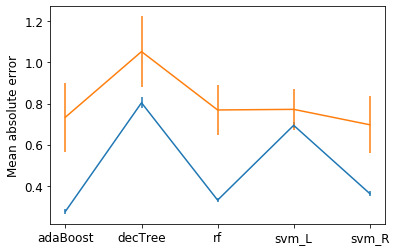

In [27]:
# plot errors
plt.figure()

names, stdTrain = zip(*sorted(maeTrainStd.items()))
names, stdTest = zip(*sorted(maeTestStd.items()))

plt.errorbar(*zip(*sorted(maeTrainMean.items())), yerr=stdTrain)
plt.errorbar(*zip(*sorted(maeTestMean.items())), yerr=stdTest)
#plt.ylim([0,1])
plt.ylabel('Mean absolute error')

plt.savefig(r'C:\DTU\Results\201901_Expt\MachineLearning\PerceivedDifficulty_mae.png', dpi=600)


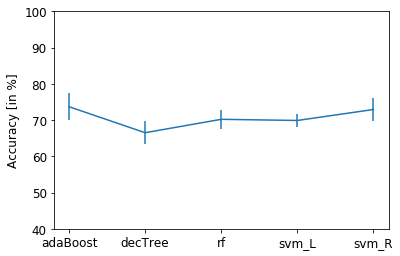

In [28]:
# plot errors
plt.figure()

names, stdAccuracy = zip(*sorted(accuracyStd.items()))

plt.errorbar(*zip(*sorted(accuracyMean.items())), yerr=stdAccuracy)

plt.ylim([40,100])
plt.ylabel('Accuracy [in %]')

plt.savefig(r'C:\DTU\Results\201901_Expt\MachineLearning\PerceivedDifficulty_accuracy.png', dpi=600)